In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
plt.style.use('arviz-darkgrid')

In [2]:
np.random.seed(42)
unknown_mean = -5
known_sigma = 3
data_points = 1000
data = np.random.normal(unknown_mean, known_sigma, size=data_points)
prior_mean = 4
prior_sigma = 2

# References - http://patricklam.org/teaching/conjugacy_print.pdf
precision = 1 / prior_sigma ** 2 + data_points / known_sigma ** 2
estimated_mean = (
    prior_mean / prior_sigma ** 2 + (data_points * np.mean(data) / known_sigma ** 2)
) / precision

In [3]:
def model(x):
    mu_prior = tf.math.exp(-(((x - prior_mean)/prior_sigma)**2)/2)/(np.sqrt(2*np.pi*(prior_sigma**2)))
    ll = mu_prior = tf.math.exp(-(((data - mu_prior)/known_sigma)**2)/2)/(np.sqrt(2*np.pi*(known_sigma**2)))
    return sum(map(tf.reduce_sum, [
        tf.math.log(mu_prior),
        tf.math.log(ll)
    ]))

In [4]:
joint_log_prob = lambda *samples: model(*samples)

In [5]:
trainable_normal = tfd.Normal(
    loc=tf.Variable(tf.random.normal([], dtype=tf.float32)),
    scale=tfp.util.TransformedVariable(1., bijector=tfb.Softplus(), dtype=tf.float32))

opt = pm.updates.adam(learning_rate=1e-2)

In [6]:
def loss_fn():
    samples = trainable_normal.sample()
    samples = trainable_normal.log_prob(samples) - joint_log_prob(samples)
    return tf.reduce_mean(samples)  # Monte carlo expectation

In [7]:
@tf.function(autograph=False)
def optimizer_fn():
    with tf.GradientTape() as tape:
        loss = loss_fn()

    watched_variables = tape.watched_variables()
    grads = tape.gradient(loss, watched_variables)
    train_op = opt.apply_gradients(zip(grads, watched_variables))
    with tf.control_dependencies([train_op]):
        return tf.identity(loss)

In [8]:
num_steps = 10_000
initial_loss = optimizer_fn()
traced_loss = tf.TensorArray(
    dtype=initial_loss.dtype,
    size=num_steps,
    clear_after_read=False,
    element_shape=initial_loss.shape,
)
traced_loss = traced_loss.write(0, initial_loss)

In [9]:
def loop_body(step, traced_loss):
    loss = optimizer_fn()
    traced_loss = traced_loss.write(step, loss)
    return [step+1, traced_loss]

In [10]:
with tf.control_dependencies([initial_loss]):
    indices, traced_loss = tf.while_loop(
        cond=lambda *x: True,
        body=loop_body,
        loop_vars=[1, traced_loss],
        parallel_iterations=1,
        maximum_iterations=num_steps - 1
    )

In [15]:
trainable_normal.mean()

<tf.Tensor: shape=(), dtype=float32, numpy=-11.371234>

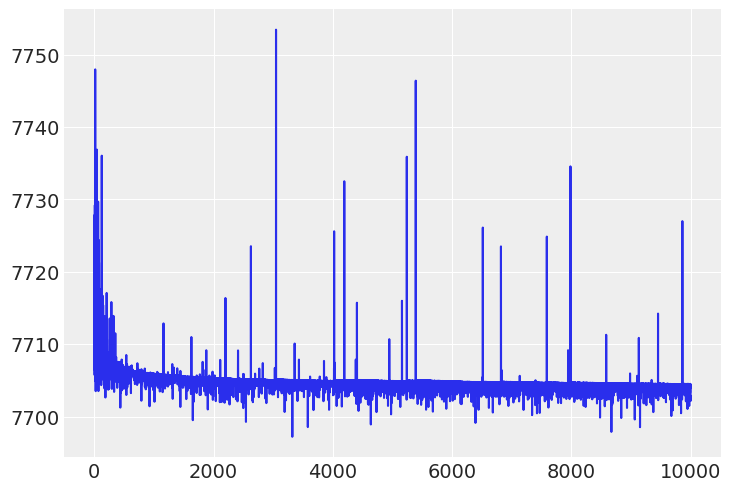

In [12]:
plt.plot(traced_loss.stack().numpy())
# plt.yscale('log')